In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from data_util import load_dfs, filter_dfs
pd.set_option('precision', 4)
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 5]
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 'x-large'

In [5]:
prefix = "../../mainstream/log"
# prefix = "../output/streamer/scheduler/combinations"
df_all, baselines_fnr = load_dfs(prefix)

In [9]:
plot_kwargs = {'x_jitter': .15, 'fit_reg': False}
metrics = ['Rel Acc Loss', 'FNR', 'FNR Loss', 'Normed FNR']

In [10]:
def plot_multiple(prefix='Avg', x_var='No of applications', fn=sns.barplot, plot_kwargs={}):
    f, ax = plt.subplots(1, len(metrics))
    for i, y_var in enumerate([prefix + ' ' + m for m in metrics]):
        fn(df_all[x_var], df_all[y_var], ax=ax[i], **plot_kwargs)
    plt.suptitle(prefix)

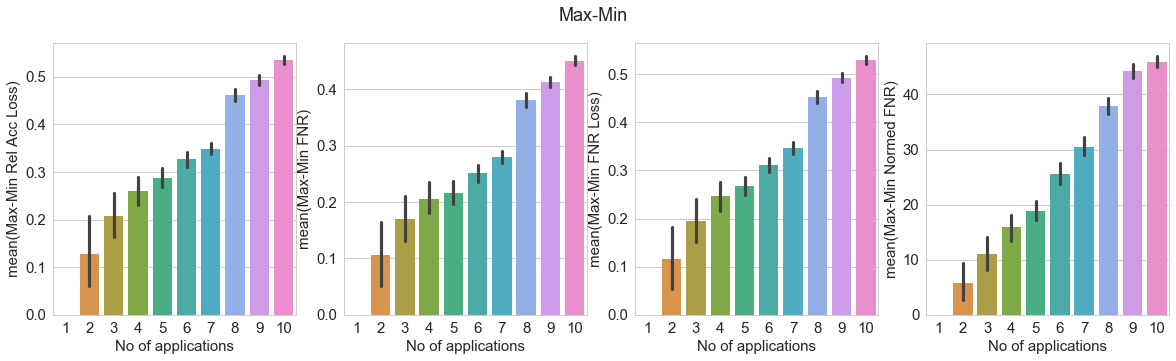

In [11]:
plot_multiple('Max-Min')

- **This graph: gap b/w best and worst in each combination.**

#### General notes
- Left to right:
    - Rel Acc Loss
    - FNR
    - **FNR Loss (`FNR - baseline`)**
    - Normed FNR (`FNR / baseline`)
- Lower = Better.
- Error bars are the std dev (rather than percentiles.)
- Normed is a multiple, whereas the range for the rest is $[0, 1]$. Y-Axis is not synchronized b/w plots.
- Combinations, not permutations

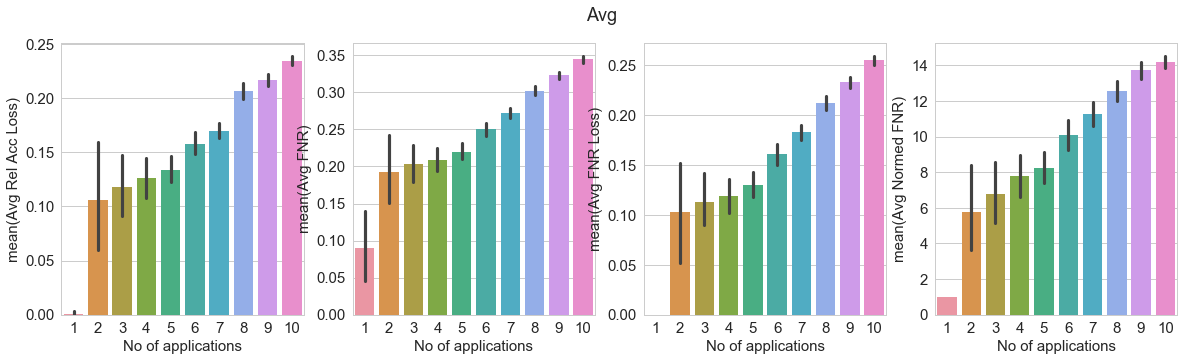

In [12]:
plot_multiple('Avg')

**This graph: avg performance in each combination.**

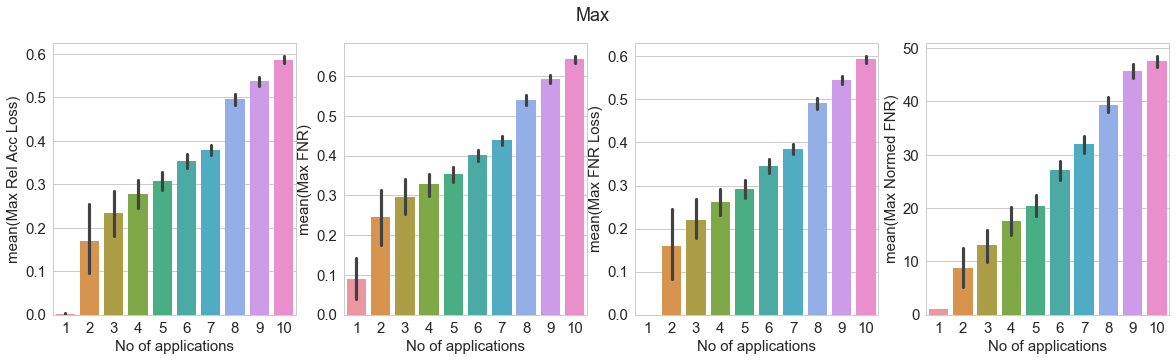

In [13]:
plot_multiple('Max')

This graph: max (**worst performing**) in each combination.

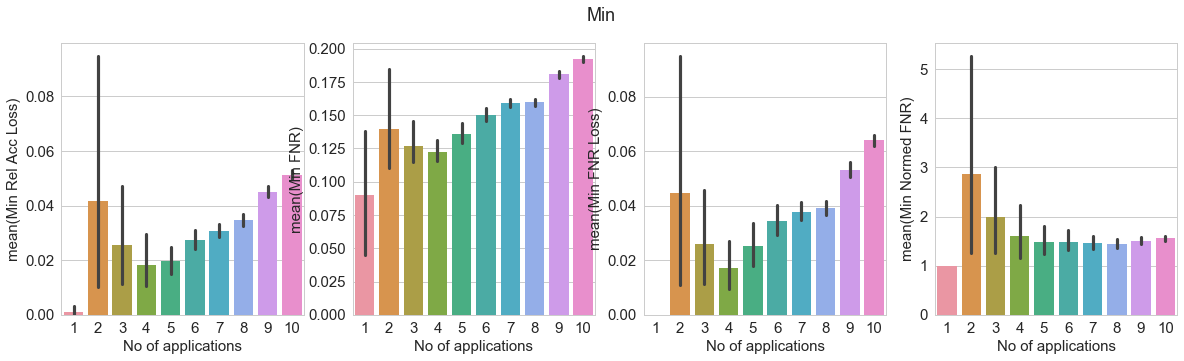

In [14]:
plot_multiple('Min')

- This graph: min (**best performing**) in each combination.
- The right-most graph (Normed FNR) appears to converge to ~1.5x.

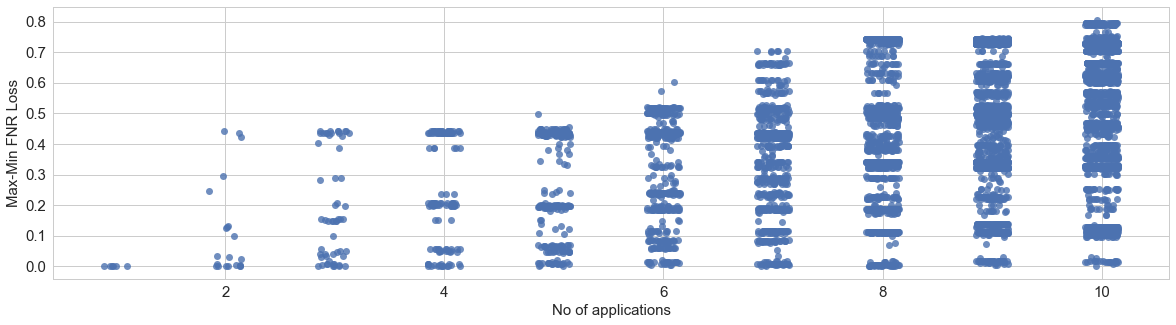

In [15]:
sns.regplot(df_all['No of applications'], df_all['Max-Min FNR Loss'], **plot_kwargs);

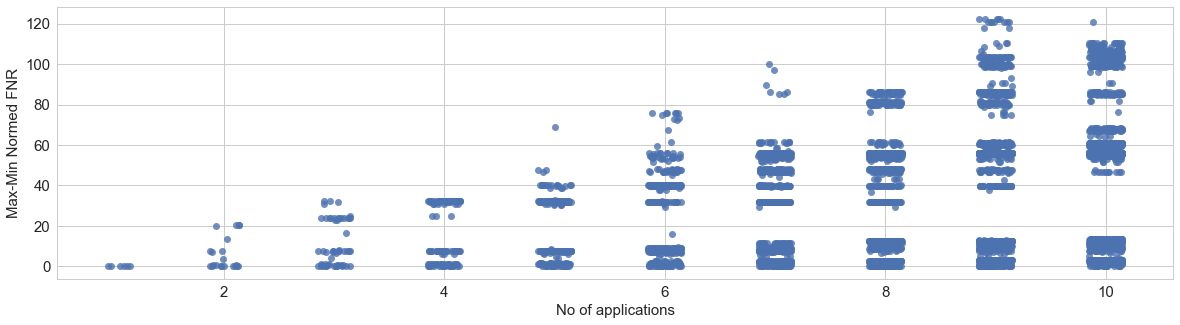

In [16]:
sns.regplot(df_all['No of applications'], df_all['Max-Min Normed FNR'], **plot_kwargs);

Spread for normed seems to be bucketed. Possibly due to some kind of 'modulo' effect (since there are only 6 values to divide by)?

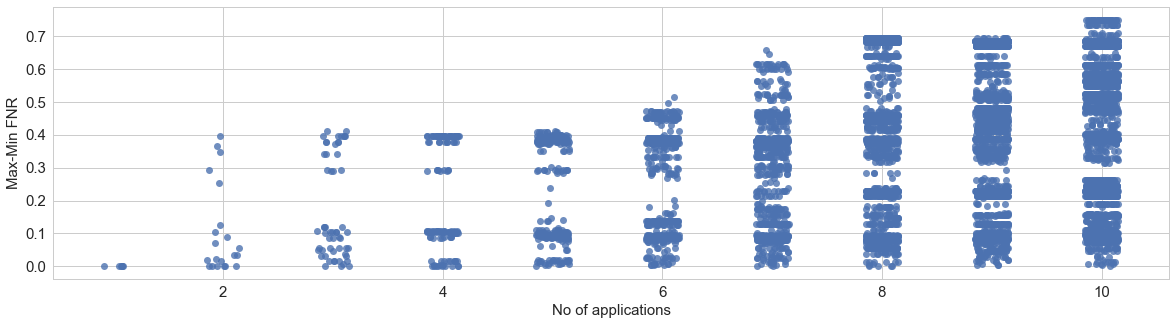

In [17]:
sns.regplot(df_all['No of applications'], df_all['Max-Min FNR'], **plot_kwargs);

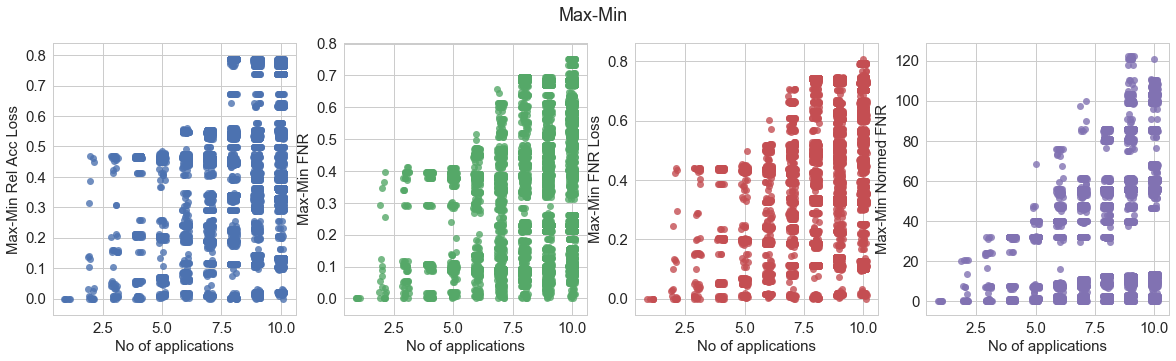

In [18]:
plot_multiple(prefix='Max-Min', fn=sns.regplot, plot_kwargs=plot_kwargs)

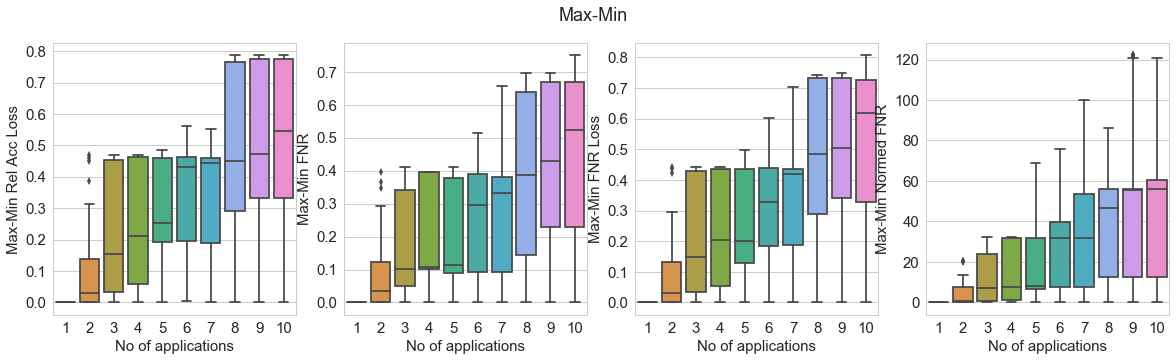

In [19]:
plot_multiple(prefix='Max-Min', fn=sns.boxplot)

In [20]:
df_all[['No of applications', 'comb', 'Avg FNR', 'Avg Rel Acc Loss', 'FNRs', 'Rel Acc Losss']]

,No of applications,comb,Avg FNR,Avg Rel Acc Loss,FNRs,Rel Acc Losss
0,1,[mean=0],0.0064,0.0064,[0.0064],[0.0064]
1,1,[mean=1],0.0511,0.0000,[0.0511],[0.0]
2,1,[mean=2],0.1166,0.0000,[0.1166],[0.0]
3,1,[mean=3],0.2004,0.0000,[0.2004],[0.0]
4,1,[mean=4],0.1048,0.0000,[0.1048],[0.0]
5,1,[mean=5],0.0596,0.0000,[0.0596],[0.0]
0,2,"[mean=0, 0]",0.1385,0.1385,"[0.138535031847, 0.138535031847]","[0.138535031847, 0.138535031847]"
1,2,"[mean=0, 1]",0.1110,0.0864,"[0.138535031847, 0.0835268592193]","[0.138535031847, 0.0341908532358]"
2,2,"[mean=0, 2]",0.1289,0.0708,"[0.138535031847, 0.1193]","[0.138535031847, 0.00305637310392]"
3,2,"[mean=0, 3]",0.1732,0.0739,"[0.138535031847, 0.2078]","[0.138535031847, 0.00925462731366]"
